What I would like to accomplish

Grab data using the world bank api
generate some useful information from the data

using plotly, create some interactive visualisations of the data

place information on a map of the world showing the values of each country on said country?

In [1]:
#Importing data libraries
import pandas as pd
import numpy as np
import world_bank_data as wb
#Importing visualisation libraries. I hope to produce at least one interactive visual with plotly.
import plotly
import plotly.offline as offline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

In [2]:
#first time using world bank data library, getting a feel for how it works.
usa = wb.get_countries(country='USA')
usa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, USA to USA
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   iso2Code     1 non-null      object 
 1   name         1 non-null      object 
 2   region       1 non-null      object 
 3   adminregion  1 non-null      object 
 4   incomeLevel  1 non-null      object 
 5   lendingType  1 non-null      object 
 6   capitalCity  1 non-null      object 
 7   longitude    1 non-null      float64
 8   latitude     1 non-null      float64
dtypes: float64(2), object(7)
memory usage: 80.0+ bytes


In [3]:
countries = wb.get_countries()
# 79 countries fall into the 'Aggregates' region, I can't place that on a map so I drop them.
countries= countries.loc[countries['region'] != 'Aggregates']
countries['region'].value_counts()

Europe & Central Asia         58
Sub-Saharan Africa            48
Latin America & Caribbean     42
East Asia & Pacific           38
Middle East & North Africa    21
South Asia                     8
North America                  3
Name: region, dtype: int64

In [4]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 218 entries, ABW to ZWE
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   iso2Code     218 non-null    object 
 1   name         218 non-null    object 
 2   region       218 non-null    object 
 3   adminregion  218 non-null    object 
 4   incomeLevel  218 non-null    object 
 5   lendingType  218 non-null    object 
 6   capitalCity  218 non-null    object 
 7   longitude    211 non-null    float64
 8   latitude     211 non-null    float64
dtypes: float64(2), object(7)
memory usage: 17.0+ KB


In [5]:
#grabbing global series data. arbitrally chose 2017
unemployment = wb.get_series('SL.UEM.TOTL.ZS',simplify_index=True, mrv=1, id_or_value='id', date= '2017')
population = wb.get_series('SP.POP.TOTL', simplify_index= True, mrv=1, id_or_value= 'id', date= '2017')
gdp = wb.get_series('NY.GDP.MKTP.CD', simplify_index= True, mrv=1, id_or_value= 'id', date= '2017')


In [6]:
#grouping data into a single dataframe
df = countries[['region', 'name', 'incomeLevel']].rename(columns={'name': 'country'})
df['unemployment'] = unemployment
df['population'] = population
df['gdp'] = gdp
df.head()

region      country          incomeLevel  \
id                                                                  
ABW  Latin America & Caribbean         Aruba          High income   
AFG                  South Asia  Afghanistan           Low income   
AGO         Sub-Saharan Africa        Angola  Lower middle income   
ALB       Europe & Central Asia      Albania  Upper middle income   
AND       Europe & Central Asia      Andorra          High income   

     unemployment  population           gdp  
id                                           
ABW           NaN    106314.0           NaN  
AFG         11.73  38041754.0  1.929110e+10  
AGO          7.70  31825295.0  8.881570e+10  
ALB         11.70   2854191.0  1.527918e+10  
AND           NaN     77142.0  3.154058e+09

In [7]:
#null values for some countries, since 32 is a small fraction of the total data dropping the rows is fine.
df.isnull().sum()

region           0
country          0
incomeLevel      0
unemployment    31
population       2
gdp             32
dtype: int64

In [8]:
df.dropna(inplace=True)
df.isnull().sum()

region          0
country         0
incomeLevel     0
unemployment    0
population      0
gdp             0
dtype: int64

In [9]:
#With no null values left, can convert the scientific value of gdp to its int equivalent
df['gdp'] = df['gdp'].astype('int64')
df.head()

region               country          incomeLevel  \
id                                                                           
AFG                  South Asia           Afghanistan           Low income   
AGO         Sub-Saharan Africa                 Angola  Lower middle income   
ALB       Europe & Central Asia               Albania  Upper middle income   
ARE  Middle East & North Africa  United Arab Emirates          High income   
ARG  Latin America & Caribbean              Argentina  Upper middle income   

     unemployment  population           gdp  
id                                           
AFG         11.73  38041754.0   19291104007  
AGO          7.70  31825295.0   88815697793  
ALB         11.70   2854191.0   15279183289  
ARE          5.00   9770529.0  421142267937  
ARG         11.67  44938712.0  445445177459

In [10]:
#looping through numerical columns and finding the countries for which the max and min of each column fall.
for col in df.columns[3:]:
    print(f'{df.loc[df[col].idxmax()]["country"]} has the highest {col} at {df[col].max().round(4)}\n{df.loc[df[col].idxmin()]["country"]} has the lowest {col} at {df[col].min().round(4)}\n')

South Africa has the highest unemployment at 28.74
Cambodia has the lowest unemployment at 0.31

China has the highest population at 1397715000.0
Tonga has the lowest population at 104494.0

United States has the highest gdp at 21433226000000
Sao Tome and Principe has the lowest gdp at 418637388



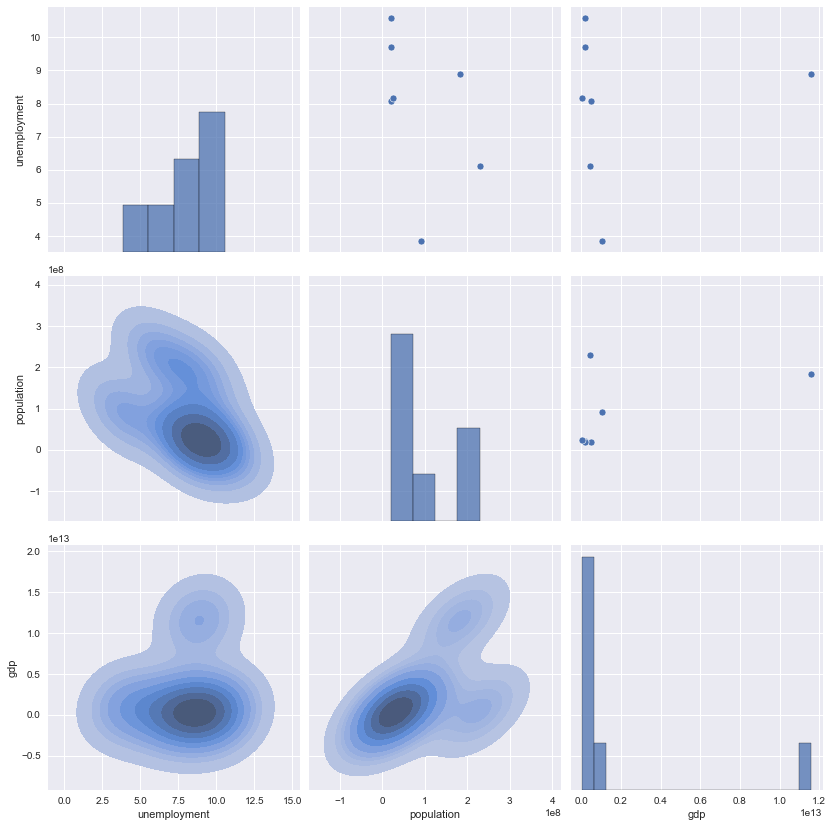

In [11]:
#creating some aggregate plots
fig= sns.pairplot(data= df.groupby(['region']).mean())
fig.fig.set_size_inches(12,12)
fig.map_lower(sns.kdeplot, shade=True)

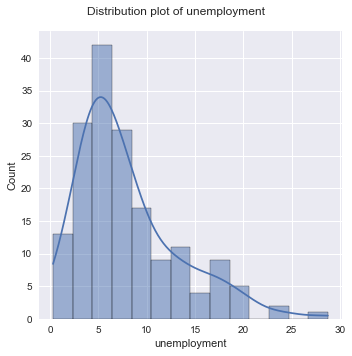

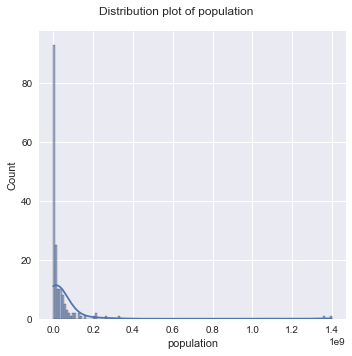

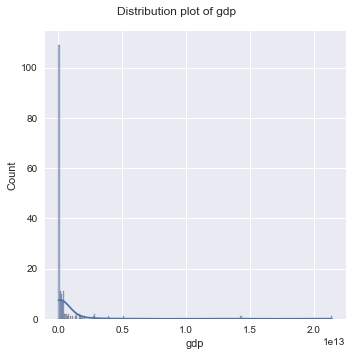

In [12]:
#visualising the distribution of the data
for x in df.columns[3:]:
    g= sns.displot(x=df[x], kde=True)
    g.fig.suptitle('Distribution plot of {}'.format(x))
    g.fig.tight_layout()

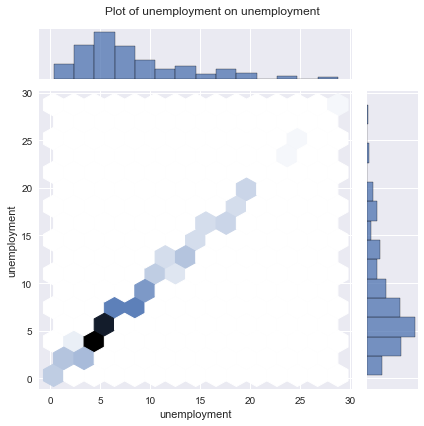

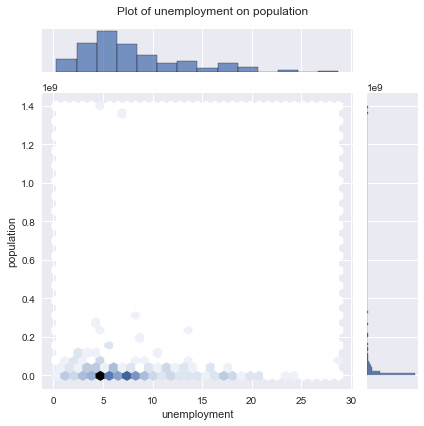

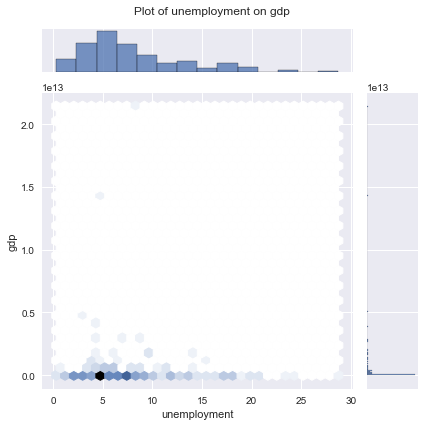

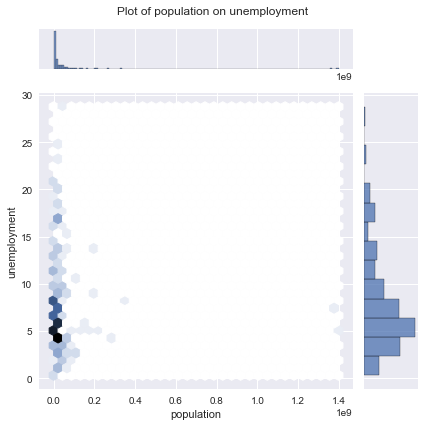

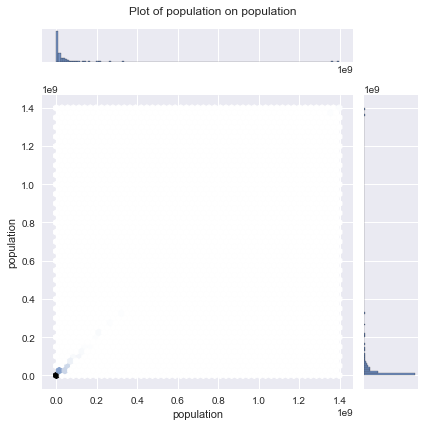

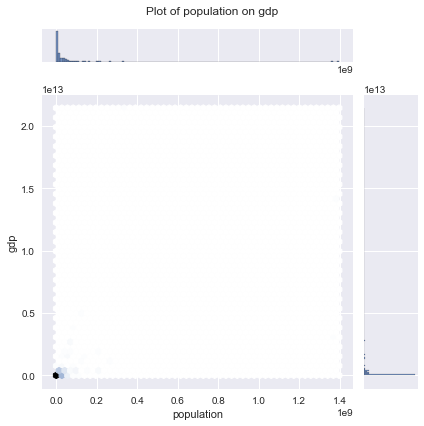

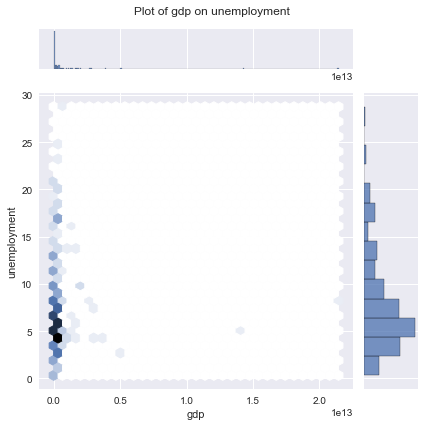

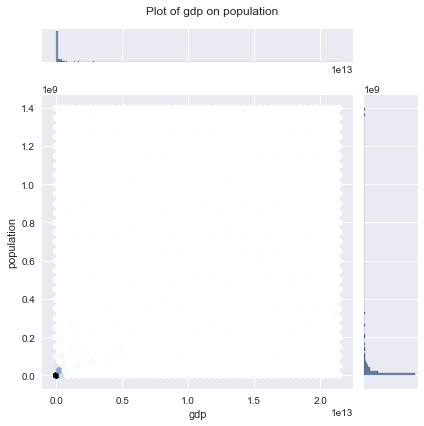

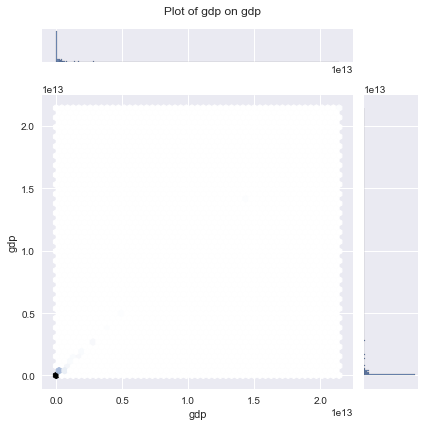

In [13]:
#looping to create some more spesific plots. The result wasn't as useful as I would have liked, I think it's because of the difference in scale of the data
for x in df.groupby(['region']).mean().columns:
    for y in df.groupby(['region']).mean().columns:
        g= sns.jointplot(data= df, x=x, y=y, kind='hex')
        g.fig.suptitle('Plot of {} on {}'.format(x,y))
        g.fig.tight_layout()